In [1]:
import pandas as pd
import random
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
import Bio.PDB.Polypeptide as pp
from os.path import join
import os
import seaborn as sns
from main_functions import *

In [2]:
figures_path = "figures/"

In [3]:
DATA = 'data/'

In [4]:
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5

In [5]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']
get_name = dict(zip(proteins, protein_names))
measures = ['nodes', 'edges', 'weight', 'distance']

In [6]:
data_path = join(DATA, 'structure')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]

In [7]:
functional_data = dict()
for protein in proteins:
    csv_file = join(DATA, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

In [8]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}

plt.rcParams.update(tex_fonts)

In [9]:
plt.rcParams["figure.facecolor"] = 'white'

In [10]:
fig_width_in = round(440.84746/72.27,1)

## Spearman correlations

In [37]:
def SpearmanR(protein, measure):
    '''Return list with Spearman correlation coefficient between mean functional data and mean perturbation network 
    data for measure by threshold. '''
    functional_mean = list(functional_data[protein].mean())
    correlations = []
    for threshold in thresholds:
        network_data = ReadNetworkCSV(protein, threshold, measure)
        network_mean = list(network_data.mean())
        correlations.append(round(stats.spearmanr(functional_mean, network_mean)[0], 3))
    return correlations

In [38]:
correlations = dict()
for measure in measures:
    for protein in proteins:
        correlations[(protein, measure)] = SpearmanR(protein, measure)

In [13]:
# control protein, we considered the protein 4bz3 (VIM2) as a representative. We considered a random permutation of 
# its positions, and for each measure and threshold, calculated the correlation between the original functional mean 
# value at each position and the corresponding perturbation score at the position given by the permutation. 
functional_mean = list(functional_data['4bz3'].mean())

# store results in dict 
results = {measure:[] for measure in measures}

for i in range(100):
    shuffled_positions = list(functional_data['4bz3'].columns).copy()
    random.shuffle(shuffled_positions) 
    for measure in measures:
        corr = []
        for threshold in thresholds:
            network_data = ReadNetworkCSV('4bz3', threshold, measure)
            network_mean = network_data.mean()
            shuffled_mean = [network_mean[pos] for pos in shuffled_positions]
            corr.append(round(sp.stats.spearmanr(functional_mean, shuffled_mean)[0], 3))
        results[measure].append(corr)
        
# add to correlations dict from above
for measure in measures:
    array = np.array(results[measure])
    correlations[('control', measure)] = array.mean(axis=0)

In [14]:
proteins

['1be9', '1d5r', '1nd4', '3dqw', '4bz3']

In [15]:
measures

['nodes', 'edges', 'weight', 'distance']

In [16]:
correlations.keys()

dict_keys([('1be9', 'nodes'), ('1d5r', 'nodes'), ('1nd4', 'nodes'), ('3dqw', 'nodes'), ('4bz3', 'nodes'), ('1be9', 'edges'), ('1d5r', 'edges'), ('1nd4', 'edges'), ('3dqw', 'edges'), ('4bz3', 'edges'), ('1be9', 'weight'), ('1d5r', 'weight'), ('1nd4', 'weight'), ('3dqw', 'weight'), ('4bz3', 'weight'), ('1be9', 'distance'), ('1d5r', 'distance'), ('1nd4', 'distance'), ('3dqw', 'distance'), ('4bz3', 'distance'), ('control', 'nodes'), ('control', 'edges'), ('control', 'weight'), ('control', 'distance')])

In [96]:
temp = []

In [97]:
for prot in proteins:
    temp.extend(correlations[(prot, 'distance')])

In [98]:
temp = [x[1] for x in temp]

In [99]:
np.mean(temp)

0.01553262804542346

In [100]:
np.std(temp)

0.053808535878362436

In [34]:
sp.stats.spearmanr

<module 'scipy.stats' from '/home/rdora/miniconda3/envs/femec/lib/python3.8/site-packages/scipy/stats/__init__.py'>

In [14]:
palette = ['#fbb4ae', '#b3cde3', '#ccebc5', '#decbe4', '#fed9a6', '#ffffcc']
palette2 = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']
palette3 = ['#7fc97f', '#beaed4', '#fdc086', '#f08080', '#386cb0', '#f0027f']

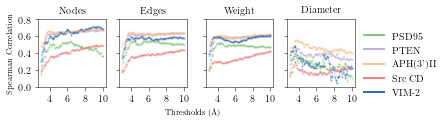

In [16]:
labels1 = ['Nodes', 'Edges', 'Weight', 'Diameter']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(fig_width_in, 0.35*fig_width_in), sharex=True, sharey=True, 
                        constrained_layout=True)

for i, measure in enumerate(measures):
    ax = axes[i]
    if i==0:
        ax.set_ylabel('Spearman Correlation', position=(0, 0.5), fontsize=8)
    if i==1:
        ax.set_xlabel('Thresholds (\AA{})', position=(1.1, 0.01), fontsize=8)
    ax.set_ylim(0,0.8)
    ax.set_xticks([4,6,8,10])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    for j,protein in enumerate(proteins):
        ax.plot(thresholds, [abs(c) for c in correlations[(protein, measure)]],
                color=palette3[j], linewidth=0.5, alpha=0.5)
        ax.scatter(thresholds, [abs(c) for c in correlations[(protein, measure)]], color=palette3[j], alpha=0.5, 
                  s=1)
        ax.plot([], [], label=protein_names[j], color=palette3[j], linewidth=2)
    #ax.plot(thresholds, correlations[('control', measure)], label='Control')
    ax.set_title(labels1[i], fontsize=10)
    ax.set_aspect(1./ax.get_data_ratio())

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1, 0.95), frameon=False)

fig.savefig("figures/correlations_fit.png", dpi=300)

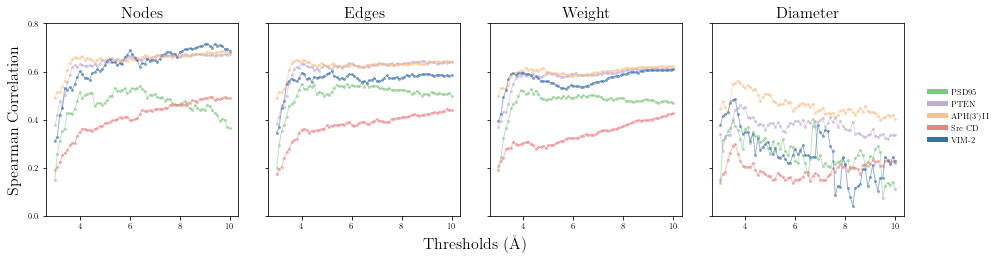

In [118]:
labels1 = ['Nodes', 'Edges', 'Weight', 'Diameter']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13,3.5), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.tight_layout()
plt.ylabel('Spearman Correlation', fontsize=16)
plt.xlabel('Thresholds (\AA{})', fontsize=16)

for i, measure in enumerate(measures):
    ax = axes[i]
    ax.set_ylim(0,0.8)
    ax.set_xticks([4,6,8,10])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    for j,protein in enumerate(proteins):
        ax.plot(thresholds, [abs(c) for c in correlations[(protein, measure)]],
                color=palette3[j], linewidth=1, alpha=0.5)
        ax.scatter(thresholds, [abs(c) for c in correlations[(protein, measure)]], color=palette3[j], alpha=0.5, 
                  s=4)
        ax.plot([], [], label=protein_names[j], color=palette3[j], linewidth=5)
    #ax.plot(thresholds, correlations[('control', measure)], label='Control')
    ax.set_title(labels1[i], fontsize=16)
    ax.set_aspect(1./ax.get_data_ratio())

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.07, 0.7), frameon=False)
#fig.tight_layout()
fig.savefig("figures/correlations.png", bbox_inches='tight', dpi=300)